# 📌 Mini Project 2: Predicting Drug Treatment from Microscopy Images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# !ls "/content/drive/My Drive"
# "/content/drive/My Drive/downsampled_data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 🧠 Prompt
> You are provided with a subset of the images present in the dataset. These images have been obtained after treatment with a small number of perturbations. Information about the type of perturbations can be extracted from the title of the file and the metadata provided. How well can you predict the drug treatment from any given image?

In [ ]:
# Predicting Drug Treatments from Cell Images (Transfer Learning + Balancing + Ensemble)

# Setup and imports
!pip install -q cellpose xgboost
!pip install -q matplotlib pandas scikit-learn seaborn opencv-python umap-learn

import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier

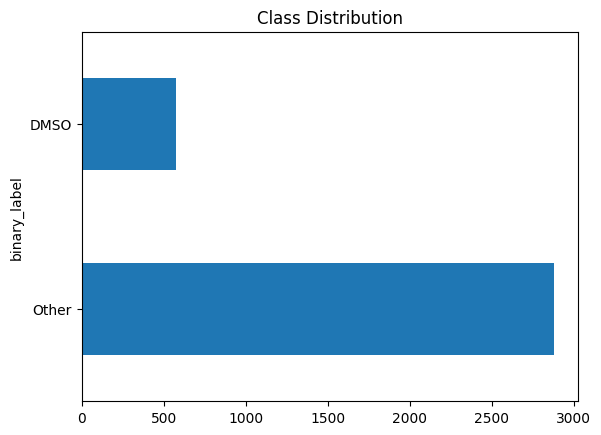

In [113]:
# Define Paths
DATA_PATH = "/content/drive/My Drive/downsampled_data"
CSV_PATH = "/content/drive/My Drive/metadata_BR00116991.csv"
CP_CSV_PATH = "/content/drive/My Drive/MyExpt_Nuclei.csv"

# Load Metadata
metadata = pd.read_csv(CSV_PATH)
metadata = metadata[metadata['Metadata_pert_iname'].notna()]
metadata['image_path'] = metadata['FileName_OrigRNA'].apply(lambda x: os.path.join(DATA_PATH, x))

# Encode Labels: Binary (DMSO vs. Other)
metadata['binary_label'] = metadata['Metadata_pert_iname'].apply(lambda x: 'DMSO' if x == 'DMSO' else 'Other')
label_to_idx = {'DMSO': 0, 'Other': 1}
metadata['label_idx'] = metadata['binary_label'].map(label_to_idx)

# Visualize Class Imbalance
metadata['binary_label'].value_counts().plot(kind='barh', title='Class Distribution')
plt.show()

In [130]:
import re

# Extract rXXcXXfXX from FileName_OrigRNA and append _median_aggregated.tiff
def build_image_path(filename):
    match = re.match(r'(r\d{2}c\d{2}f\d{2})', filename)
    if match:
        core = match.group(1)
        return os.path.join(DATA_PATH, f"{core}_median_aggregated.tiff")
    else:
        return None  # optional: filter out later

metadata['image_path'] = metadata['FileName_OrigRNA'].apply(build_image_path)

In [134]:
from joblib import Parallel, delayed
from tqdm import tqdm

# Reload the same loader function you already have
def load_image(path, size=(128, 128)):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return np.zeros((*size, 3))
    img = cv2.resize(img, size)
    return np.stack([img]*3, axis=-1) / 255.0

# Fast loading with progress bar!
IMG_SIZE = (128, 128)
X = np.array(
    Parallel(n_jobs=-1)(
        delayed(load_image)(p, IMG_SIZE) for p in tqdm(metadata['image_path'])
    )
)

# Labels
Y = to_categorical(metadata['label_idx'])

100%|██████████| 3456/3456 [02:09<00:00, 26.72it/s] 


In [136]:
# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

# Data Augmentation
aug = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

# Define Transfer Learning Model (MobileNetV2 base)
base_model = MobileNetV2(include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), weights='imagenet')
base_model.trainable = False
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the CNN model
history = model.fit(aug.flow(X_train, y_train, batch_size=32), validation_data=(X_test, y_test), epochs=10)

# Evaluate model on test set
loss, acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {acc:.2f}")


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 62s 624ms/step - accuracy: 0.7781 - loss: 0.6228 - val_accuracy: 0.8338 - val_loss: 0.4379
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 84s 647ms/step - accuracy: 0.8257 - loss: 0.4548 - val_accuracy: 0.8338 - val_loss: 0.4398
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 79s 615ms/step - accuracy: 0.8374 - loss: 0.4502 - val_accuracy: 0.8338 - val_loss: 0.4247
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 55s 628ms/step - accuracy: 0.8381 - loss: 0.4284 - val_accuracy: 0.8338 - val_loss: 0.4466
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 54s 619ms/step - accuracy: 0.8404 - loss: 0.4336 - val_accuracy: 0.8338 - val_loss: 0.4261
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 54s 619ms/step - accuracy: 0.8414 - loss: 0.4365 - val_accuracy: 0.8338 - val_loss: 0.4225
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 82s 623ms/step - accuracy: 0.8351 - loss: 0.4402 - val_accuracy: 0.8338 - val_loss: 0.4321
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 54s 625ms/step - accuracy: 0.8402 - loss: 0.4162 - val_accu

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 343ms/step
              precision    recall  f1-score   support

        DMSO       0.00      0.00      0.00       115
       Other       0.83      1.00      0.91       577

    accuracy                           0.83       692
   macro avg       0.42      0.50      0.45       692
weighted avg       0.70      0.83      0.76       692



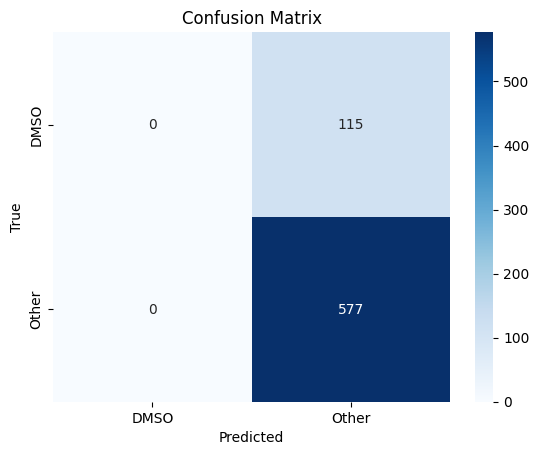

In [141]:
import warnings
warnings.filterwarnings('ignore')

# Classification Report (Binary: DMSO vs Other)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=['DMSO', 'Other']))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['DMSO', 'Other'], yticklabels=['DMSO', 'Other'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
# Improve Class Balancing (via class_weight)
from sklearn.utils import class_weight

# Compute class weights from training labels
y_integers = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)
class_weights_dict = dict(enumerate(class_weights))

# Add class_weight to model.fit()
history = model.fit(
    aug.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=10,
    class_weight=class_weights_dict)

Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 65s 632ms/step - accuracy: 0.8404 - loss: 0.7317 - val_accuracy: 0.8338 - val_loss: 0.6232
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 51s 590ms/step - accuracy: 0.8323 - loss: 0.7001 - val_accuracy: 0.8338 - val_loss: 0.6485
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 56s 649ms/step - accuracy: 0.8367 - loss: 0.6887 - val_accuracy: 0.8338 - val_loss: 0.6612
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 54s 620ms/step - accuracy: 0.8352 - loss: 0.6904 - val_accuracy: 0.8338 - val_loss: 0.6726
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 55s 628ms/step - accuracy: 0.8363 - loss: 0.6883 - val_accuracy: 0.8338 - val_loss: 0.6764
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 54s 622ms/step - accuracy: 0.8278 - loss: 0.7028 - val_accuracy: 0.8338 - val_loss: 0.6850
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 55s 624ms/step - accuracy: 0.8297 - loss: 0.6992 - val_accuracy: 0.8338 - val_loss: 0.6886
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 66s 761ms/step - accuracy: 0.8515 - loss: 0.6623 - val_accu

22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 412ms/step


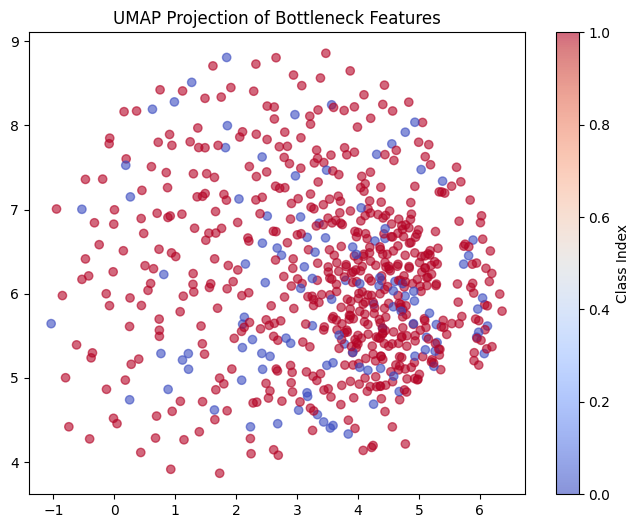

In [ ]:
# UMAP Visualization of Bottleneck Features
embed_model = Model(inputs=model.input, outputs=model.layers[-3].output)
features = embed_model.predict(X_test)

import umap
features_scaled = StandardScaler().fit_transform(features)
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(features_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=y_true_classes, cmap='coolwarm', alpha=0.6)
plt.title("UMAP Projection of Bottleneck Features")
plt.colorbar(label='Class Index')
plt.show()

In [137]:
# Replace X_test with the correct CNN test image array
X_test_cnn = X_test
y_test_cnn = y_test

# Predict with CNN
y_pred_probs = model.predict(X_test_cnn)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test_cnn, axis=1)

# Indices
correct_idx = np.where(y_pred_labels == y_true_labels)[0]
incorrect_idx = np.where(y_pred_labels != y_true_labels)[0]

22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 430ms/step


Model Accuracy on Test Set: 83.38%


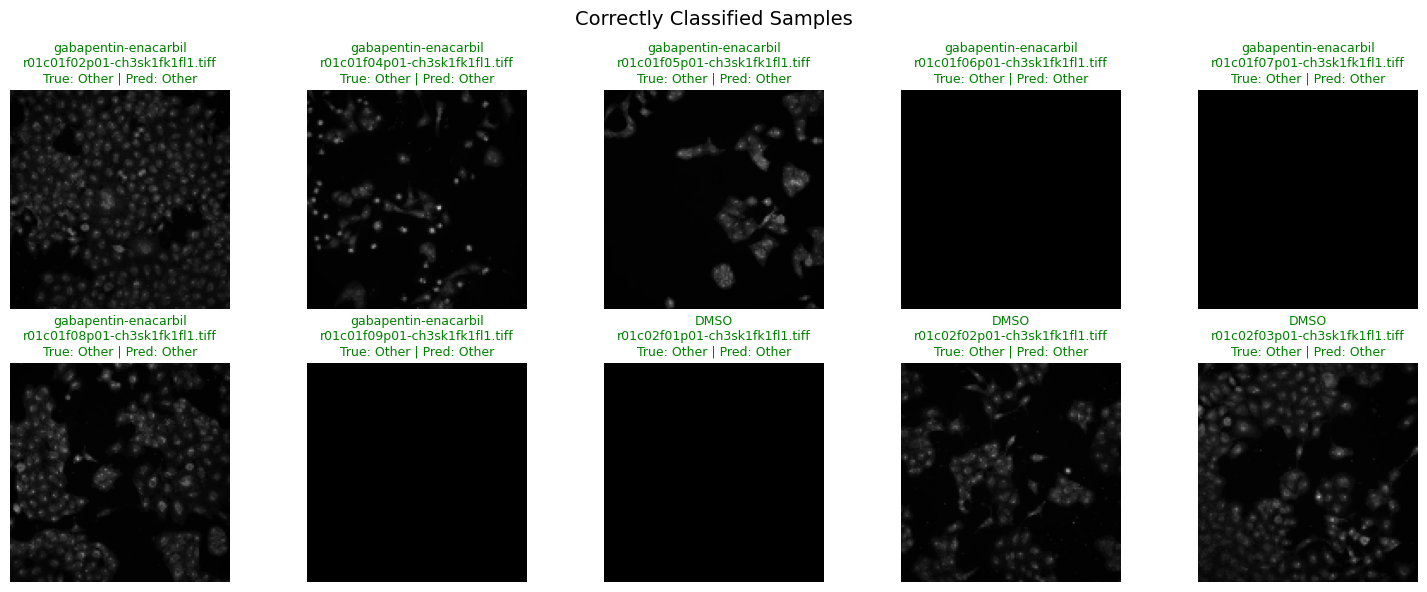

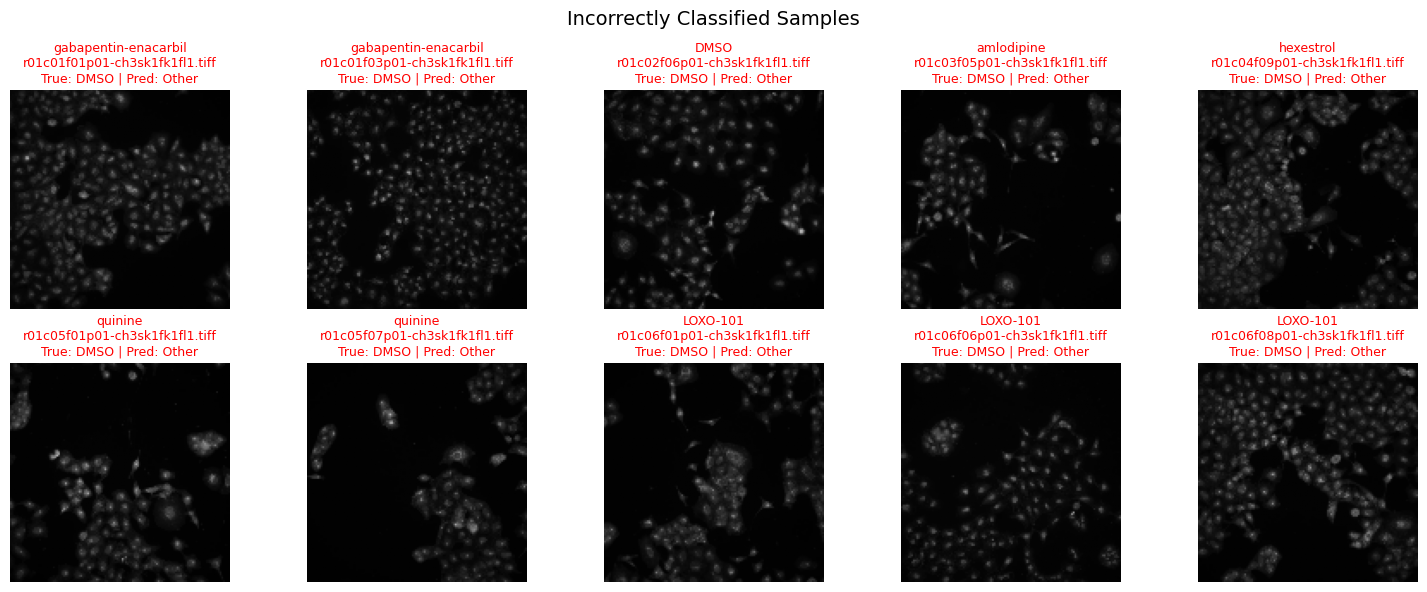

In [162]:
def show_samples_enhanced(indices, title, max_samples=10):
    plt.figure(figsize=(15, 6))

    # Use entire metadata index as fallback
    test_indices = metadata.index.to_list()

    for i in range(min(max_samples, len(indices))):
        idx = indices[i]
        img = X_test_cnn[idx]

        # Show grayscale image properly
        plt.subplot(2, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')

        # Get metadata
        true_class = 'DMSO' if y_true_labels[idx] == 0 else 'Other'
        pred_class = 'DMSO' if y_pred_labels[idx] == 0 else 'Other'
        filename = metadata.iloc[test_indices[idx]]['FileName_OrigRNA']
        compound = metadata.iloc[test_indices[idx]]['Metadata_pert_iname']

        # Title coloring
        color = 'green' if true_class == pred_class else 'red'

        plt.title(
            f"{compound}\n{filename}\nTrue: {true_class} | Pred: {pred_class}",
            fontsize=9, color=color
        )

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Compute model accuracy
acc = np.mean(y_pred_labels == y_true_labels)
print(f"Model Accuracy on Test Set: {acc:.2%}")

# Show top N correctly classified images
show_samples_enhanced(correct_idx, "Correctly Classified Samples")

# Show top N incorrectly classified images
show_samples_enhanced(incorrect_idx, "Incorrectly Classified Samples")

🔎 Model Accuracy on Test Set: 83.38%


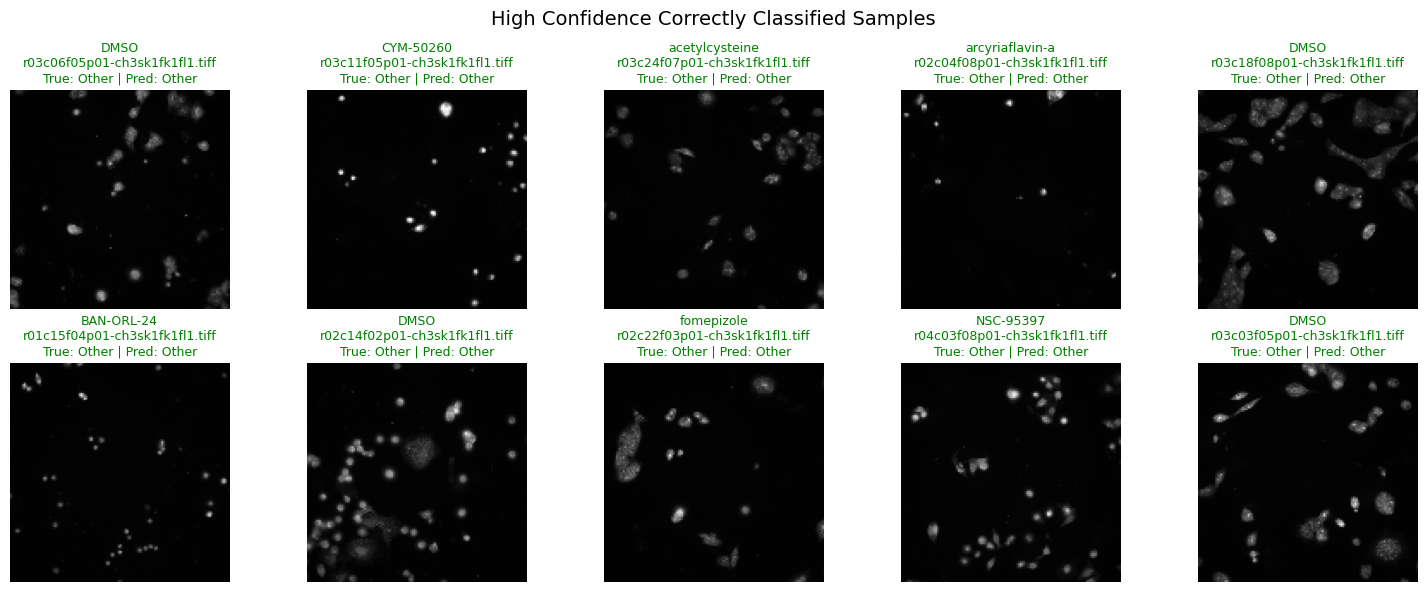

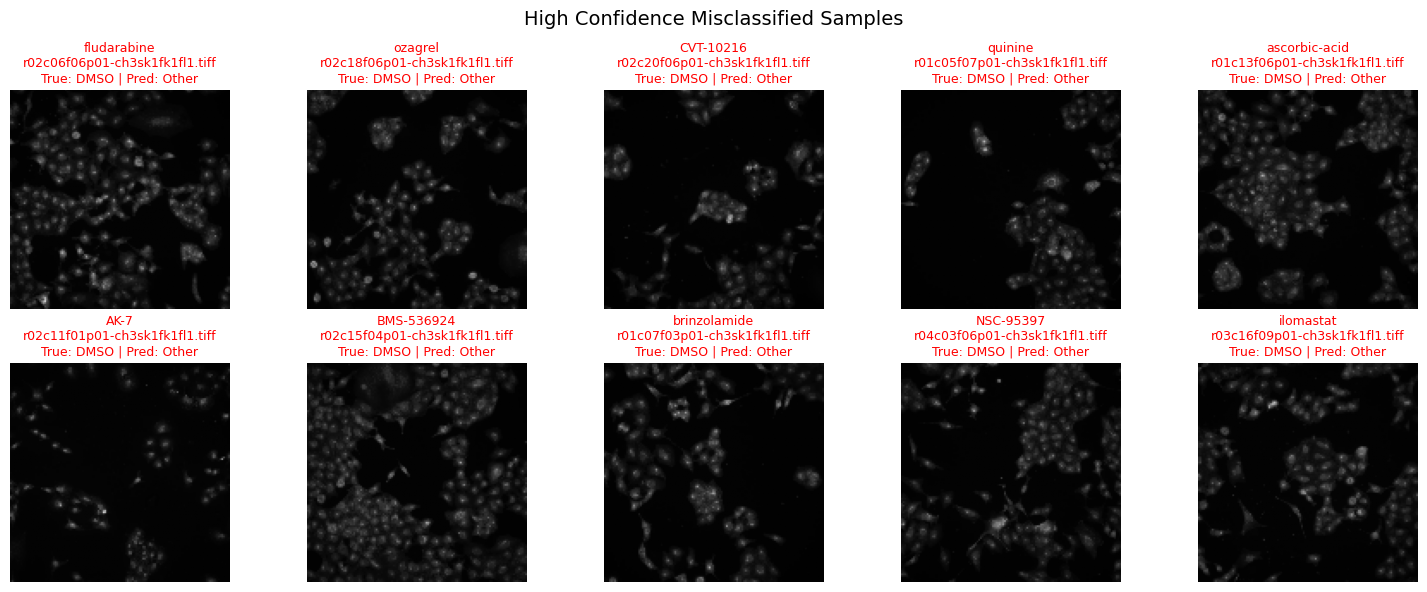

In [165]:
acc = np.mean(y_pred_labels == y_true_labels)
print(f"🔎 Model Accuracy on Test Set: {acc:.2%}")

# Sort by max probability (confidence)
confidences = np.max(y_pred_probs, axis=1)

# Top correct predictions with highest confidence
high_conf_correct = correct_idx[np.argsort(-confidences[correct_idx])][:10]
show_samples_enhanced(high_conf_correct, "High Confidence Correctly Classified Samples")

# Most confident incorrect predictions (wrong but confident)
high_conf_wrong = incorrect_idx[np.argsort(-confidences[incorrect_idx])][:10]
show_samples_enhanced(high_conf_wrong, "High Confidence Misclassified Samples")

**Multi-Class Compound Classification Using Transfer Learning**

In [154]:
# Select the top N most frequent compounds
TOP_N = 10
compound_counts = metadata['Metadata_pert_iname'].value_counts()
top_compounds = compound_counts.nlargest(TOP_N).index.tolist()

# Filter to include only samples from top N compounds
df_top = metadata[metadata['Metadata_pert_iname'].isin(top_compounds)].copy()

# Encode compound names to numerical indices
df_top['label_idx'] = df_top['Metadata_pert_iname'].astype('category').cat.codes

# Create dictionaries for label ↔ name mapping
compound_to_idx = dict(zip(df_top['Metadata_pert_iname'].unique(), df_top['label_idx'].unique()))
idx_to_compound = {v: k for k, v in compound_to_idx.items()}

In [155]:
# Image loading parameters
IMG_SIZE = (128, 128)

# Load image data and normalize
X_mc = np.array([load_image(p, IMG_SIZE) for p in df_top['image_path']])
y_mc = to_categorical(df_top['label_idx'])

# Train–test split (stratified)
X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(
    X_mc, y_mc, test_size=0.2, stratify=y_mc, random_state=42
)

In [ ]:
from tensorflow.keras import backend as K

# Define focal loss (for multi-class/balanced issues)
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1. - y_pred, gamma)
        loss = weight * cross_entropy
        return K.mean(K.sum(loss, axis=-1))
    return focal_loss_fixed

# Define Transfer Learning Model (MobileNetV2)
from tensorflow.keras.callbacks import EarlyStopping
base_model_mc = MobileNetV2(include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), weights='imagenet')
base_model_mc.trainable = False

# Add custom classification head
x = base_model_mc.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(TOP_N, activation='softmax')(x)
model_mc = Model(inputs=base_model_mc.input, outputs=output)

# Compile your model with focal loss
model_mc.compile(
    optimizer='adam',
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=['accuracy']
)

In [ ]:
from sklearn.utils import class_weight

# Compute class weights
y_integers = np.argmax(y_train_mc, axis=1)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)
class_weights_dict = dict(enumerate(class_weights))

# Fit the model with class_weight + early stopping
history_mc = model_mc.fit(
    aug.flow(X_train_mc, y_train_mc, batch_size=32),
    validation_data=(X_test_mc, y_test_mc),
    epochs=10,
    class_weight=class_weights_dict,   # Class weights
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7340 - loss: 0.2137 - val_accuracy: 0.7770 - val_loss: 0.1772
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 803ms/step - accuracy: 0.7556 - loss: 0.2304 - val_accuracy: 0.7770 - val_loss: 0.1789
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 686ms/step - accuracy: 0.7757 - loss: 0.2121 - val_accuracy: 0.7770 - val_loss: 0.1788
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 683ms/step - accuracy: 0.7940 - loss: 0.1970 - val_accuracy: 0.7770 - val_loss: 0.1754
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 623ms/step - accuracy: 0.8015 - loss: 0.1805 - val_accuracy: 0.7770 - val_loss: 0.1752
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 698ms/step - accuracy: 0.7651 - loss: 0.2190 - val_accuracy: 0.7770 - val_loss: 0.1747
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 678ms/step - accuracy: 0.7936 - loss: 0.1874 - val_accuracy: 0.7770 - val_loss: 0.1764
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 629ms/step - accuracy: 0.7758 - loss: 0.2086 - val_accurac

In [ ]:
# Evaluate test set performance
loss, acc = model_mc.evaluate(X_test_mc, y_test_mc)
print(f"Test Accuracy: {acc:.4f}")

# Generate predictions and classification report
y_pred_mc = np.argmax(model_mc.predict(X_test_mc), axis=1)
y_true_mc = np.argmax(y_test_mc, axis=1)

from sklearn.metrics import classification_report
print(classification_report(
    y_true_mc, y_pred_mc,
    target_names=[idx_to_compound[i] for i in range(TOP_N)]
))


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 329ms/step - accuracy: 0.7690 - loss: 0.1786
Test Accuracy: 0.7770
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 681ms/step
               precision    recall  f1-score   support

      BI-2536       0.00      0.00      0.00         4
         DMSO       0.78      1.00      0.87       115
       FK-866       0.00      0.00      0.00         3
  PF-03758309       0.00      0.00      0.00         4
     ZK-93423       0.00      0.00      0.00         3
  azacitidine       0.00      0.00      0.00         4
   buparlisib       0.00      0.00      0.00         4
dexamethasone       0.00      0.00      0.00         4
   ganetespib       0.00      0.00      0.00         3
 thiostrepton       0.00      0.00      0.00         4

     accuracy                           0.78       148
    macro avg       0.08      0.10      0.09       148
 weighted avg       0.60      0.78      0.68       148



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


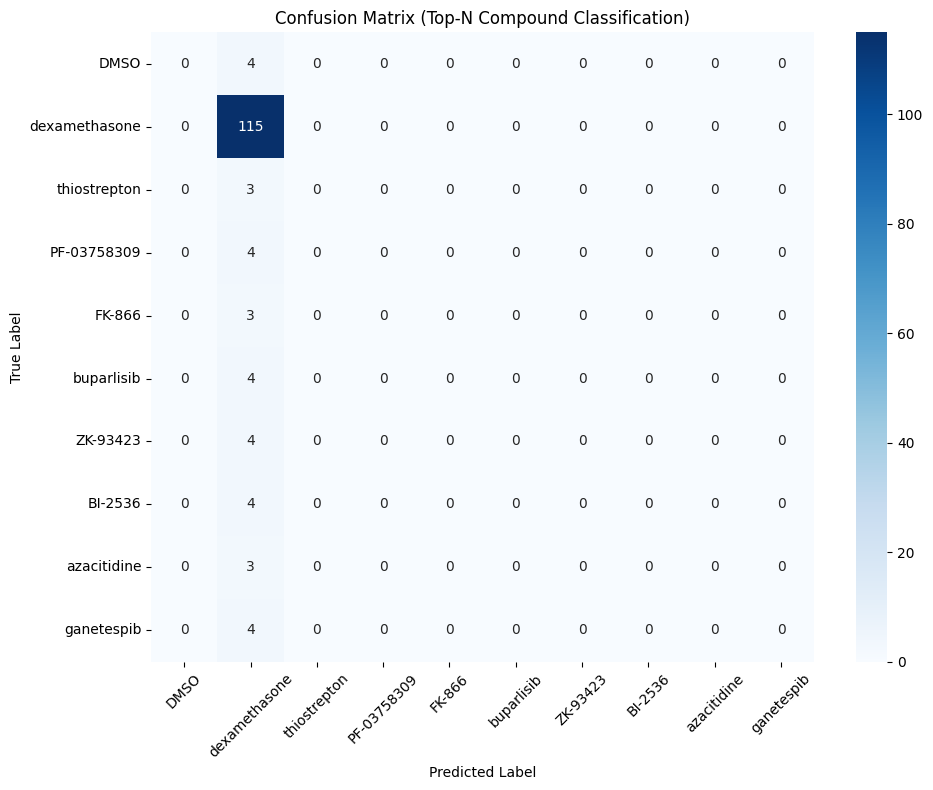

In [157]:
# Plot confusion matrix for Top-N compound classification
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true_mc, y_pred_mc)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=idx_to_compound.values(),
            yticklabels=idx_to_compound.values(),
            cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Top-N Compound Classification)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 654ms/step


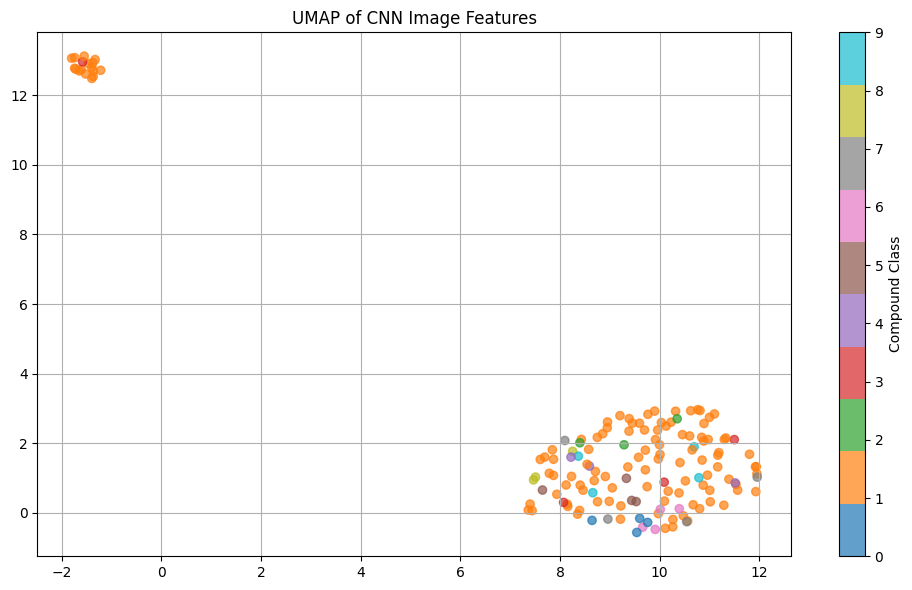

In [159]:
# Extract CNN image embeddings
from sklearn.preprocessing import StandardScaler
import umap

feature_extractor = Model(inputs=model_mc.input, outputs=model_mc.layers[-3].output)
features = feature_extractor.predict(X_test_mc)
features_scaled = StandardScaler().fit_transform(features)

# Run UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(features_scaled)

# Plot UMAP of CNN embeddings
plt.figure(figsize=(10, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=y_true_mc, cmap='tab10', alpha=0.7)
plt.title('UMAP of CNN Image Features')
plt.colorbar(scatter, ticks=range(TOP_N), label='Compound Class')
plt.grid(True)
plt.tight_layout()
plt.show()


**Drug Classification Using CellProfiler Features: From Preprocessing to Visualization**

In [ ]:
# Import Required Libraries
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Load and Merge CellProfiler + Metadata
cp_df = pd.read_csv('/content/drive/My Drive/MyExpt_Nuclei.csv', low_memory=False)
meta_df = pd.read_csv('/content/drive/My Drive/metadata_BR00116991.csv')

# Create merge key for joining
cp_df['merge_key'] = cp_df['FileName_Cells'].str[:9]
meta_df['merge_key'] = meta_df['FileName_OrigRNA'].str[:9]

# Aggregate Features and Merge with Metadata
non_features = ['ImageNumber', 'ObjectNumber', 'FileName_Cells', 'PathName_Cells']
feature_cols = [col for col in cp_df.columns if col not in non_features and cp_df[col].dtype in ['float64', 'int64']]

# Aggregate CellProfiler features
agg_cp_df = cp_df.groupby('merge_key')[feature_cols].mean().reset_index()

# Merge with metadata
merged_df = pd.merge(agg_cp_df, meta_df, on='merge_key', how='inner')

In [ ]:
# Sample, Impute, and Scale Features
sample_keys = merged_df['merge_key'].drop_duplicates().sample(n=300, random_state=42)
merged_sampled = merged_df[merged_df['merge_key'].isin(sample_keys)]

# Drop columns with all missing values before imputation
cleaned_features = merged_sampled[feature_cols].dropna(axis=1, how='all')

# Impute missing
imputer = SimpleImputer(strategy='mean')
imputed_features = imputer.fit_transform(cleaned_features)

# Standardize
scaler = StandardScaler()
scaled = scaler.fit_transform(imputed_features)

In [ ]:
# Dimensionality Reduction with PCA
pca = PCA(n_components=50)
pca_features = pca.fit_transform(scaled)

# Add labels for classification
pca_df = pd.DataFrame(pca_features, columns=[f'pca_{i+1}' for i in range(pca_features.shape[1])])
pca_df['label'] = merged_sampled['Metadata_pert_iname']

In [ ]:
# Filter Low-Frequency Drug Classes
label_counts = pca_df['label'].value_counts()
valid_classes = label_counts[label_counts >= 2].index
pca_df = pca_df[pca_df['label'].isin(valid_classes)]

In [ ]:
# Train-Test Split (Stratified)
X = pca_df.drop(columns=['label'])
y = pca_df['label']

n_classes = y.nunique()
min_test_size = n_classes / len(y) + 0.01
test_size = max(0.2, min_test_size)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=test_size, random_state=42
)

In [ ]:
# Build a multi-class classifier using CellProfiler features
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Generate metrics to assess the classifier
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, zero_division=0))

=== Classification Report ===
              precision    recall  f1-score   support

        DMSO       0.50      1.00      0.67         1
    NS-11021       0.25      1.00      0.40         1
        PP-1       0.00      0.00      0.00         1
    ZK811752       0.00      0.00      0.00         1
   hexestrol       0.00      0.00      0.00         2

    accuracy                           0.33         6
   macro avg       0.15      0.40      0.21         6
weighted avg       0.12      0.33      0.18         6



<ipython-input-29-bc0f4bdde693>:8: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


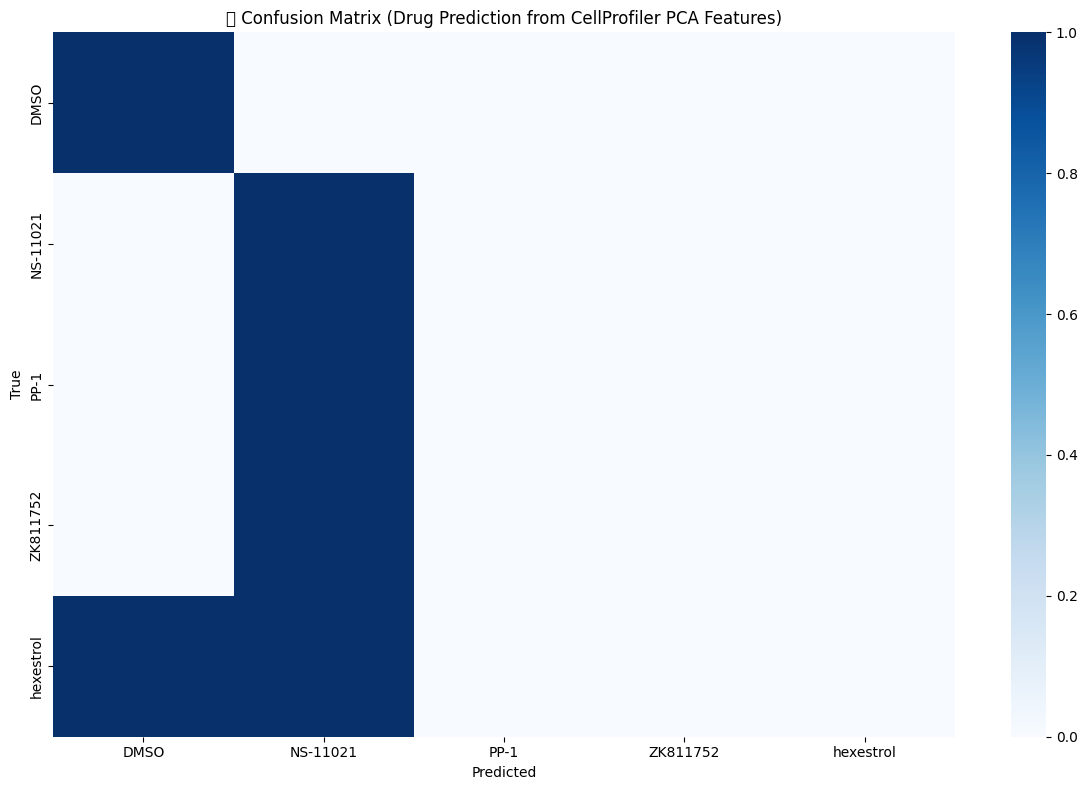

In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
sns.heatmap(cm, annot=False, xticklabels=clf.classes_, yticklabels=clf.classes_, cmap='Blues')
plt.title("📊 Confusion Matrix (Drug Prediction from CellProfiler PCA Features)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
<ipython-input-30-cdf3eb599987>:14: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


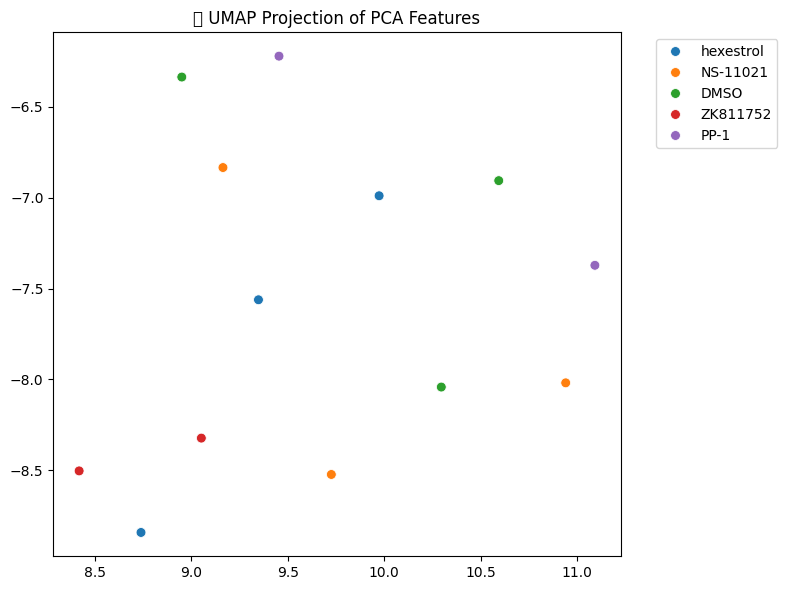

<ipython-input-30-cdf3eb599987>:30: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


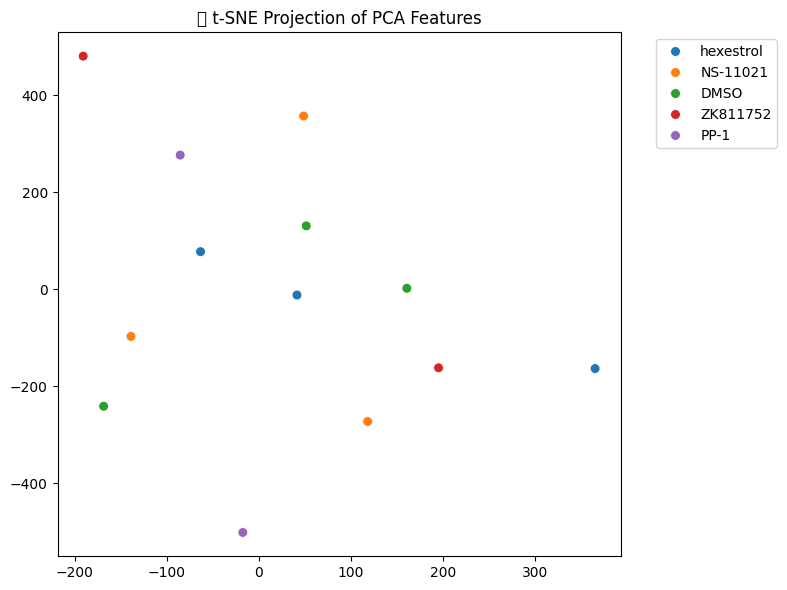

In [ ]:
# UMAP Visualization of PCA Features
import umap.umap_ as umap

pca_features_only = pca_df.drop(columns=['label']).values
labels = pca_df['label'].values

umap_model = umap.UMAP(n_neighbors=5, random_state=42)
umap_proj = umap_model.fit_transform(pca_features_only)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=umap_proj[:, 0], y=umap_proj[:, 1], hue=labels, palette='tab10', s=50)
plt.title("🔍 UMAP Projection of PCA Features")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# t-SNE Visualization of PCA Features
from sklearn.manifold import TSNE

n_samples = pca_features_only.shape[0]
adjusted_perplexity = min(30, max(2, n_samples // 3))  # safe default

tsne_model = TSNE(n_components=2, perplexity=adjusted_perplexity, random_state=42)
tsne_proj = tsne_model.fit_transform(pca_features_only)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_proj[:, 0], y=tsne_proj[:, 1], hue=labels, palette='tab10', s=50)
plt.title("🔍 t-SNE Projection of PCA Features")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


**Ensemble Learning for Drug Response Classification using CNN and CellProfiler Features with Visualization & Evaluation**

In [ ]:
# Merge with Metadata (Top-N Only)
meta_df_top = meta_df[meta_df['Metadata_pert_iname'].isin(top_compounds)].copy()
meta_df_top['label_idx'] = meta_df_top['Metadata_pert_iname'].astype('category').cat.codes
merged_cp = pd.merge(agg_cp_df, meta_df_top, on='merge_key', how='inner')

# Prepare Features and Labels
cp_features = merged_cp[feature_cols]
y_cp = merged_cp['label_idx']

# Impute and Scale Features
cp_features = cp_features.dropna(axis=1, how='all')
imputer = SimpleImputer(strategy='mean')
scaled_cp = StandardScaler().fit_transform(imputer.fit_transform(cp_features))

In [ ]:
#  Multi-class balancing for CellProfiler features using oversampling
!pip install -q imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight

# Resample CellProfiler features using RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled_cp, y_resampled_cp = ros.fit_resample(scaled_cp, y_cp)

print(f"Resampled shape: {X_resampled_cp.shape}, label distribution: {np.bincount(y_resampled_cp)}")

# Stratified train-test split on resampled data
X_train_cp, X_test_cp, y_train_cp, y_test_cp = train_test_split(
    X_resampled_cp, y_resampled_cp, test_size=0.2, stratify=y_resampled_cp, random_state=42
)

# Compute class weights if you prefer class_weight over oversampling
class_weights_cp = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_resampled_cp),
    y=y_resampled_cp
)
class_weights_cp_dict = dict(enumerate(class_weights_cp))

Resampled shape: (5090, 130), label distribution: [509 509 509 509 509 509 509 509 509 509]


In [ ]:
from xgboost import XGBClassifier

# Define XGBoost model without deprecated param
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    eval_metric='mlogloss',
    random_state=42
)

# Optional: compute sample weights using class_weights_cp_dict
sample_weights = np.array([class_weights_cp_dict[label] for label in y_train_cp])

# Fit the model with sample_weight
xgb.fit(X_train_cp, y_train_cp, sample_weight=sample_weights)

# Predict probabilities for ensemble
cp_probs = xgb.predict_proba(X_test_cp)


In [ ]:
# Combine CellProfiler and CNN Predictions (Correct Alignment)

# Add original index to meta_df_top before resampling
if 'index' in meta_df_top.columns:
    meta_df_top = meta_df_top.drop(columns=['index'])

meta_df_top = meta_df_top.reset_index(drop=False)  # Save original index as 'index'
scaled_cp = pd.DataFrame(scaled_cp)                # Ensure it's a DataFrame
scaled_cp.columns = scaled_cp.columns.astype(str)  # Convert all column names to string
scaled_cp['orig_index'] = meta_df_top['index']

# Resample CellProfiler features and labels
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled_cp, y_resampled_cp = ros.fit_resample(scaled_cp, y_cp)

# Reconstruct metadata aligned to resampled y_cp
resampled_meta_cp = meta_df_top.iloc[X_resampled_cp['orig_index']].reset_index(drop=True)
resampled_meta_cp['merge_key'] = resampled_meta_cp['FileName_OrigRNA'].str[:9]

# Split metadata alongside X/y
meta_train_cp, meta_test_cp = train_test_split(
    resampled_meta_cp, test_size=0.2, stratify=y_resampled_cp, random_state=42
)

# Extract matching merge keys for test set
test_keys_cp = meta_test_cp['merge_key'].values

# Align test CNN inputs by merge_key from df_top
test_keys_cnn = df_top[df_top['merge_key'].isin(test_keys_cp)].copy()
test_keys_cnn = test_keys_cnn.drop_duplicates(subset='merge_key').set_index('merge_key').loc[test_keys_cp]

# Get CNN inputs and predictions for aligned test set
X_test_mc_aligned = np.array([load_image(p, IMG_SIZE) for p in test_keys_cnn['image_path']])
cnn_probs_aligned = model_mc.predict(X_test_mc_aligned)

# Late fusion ensemble
avg_probs = (cp_probs + cnn_probs_aligned) / 2
ensemble_preds = np.argmax(avg_probs, axis=1)

# Evaluate ensemble accuracy
from sklearn.metrics import accuracy_score
ensemble_acc = accuracy_score(y_test_cp, ensemble_preds)
print(f"✅ Ensemble Accuracy (Aligned): {ensemble_acc:.4f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 788ms/step
✅ Ensemble Accuracy (Aligned): 0.9971


<ipython-input-55-bbd928bb7d43>:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


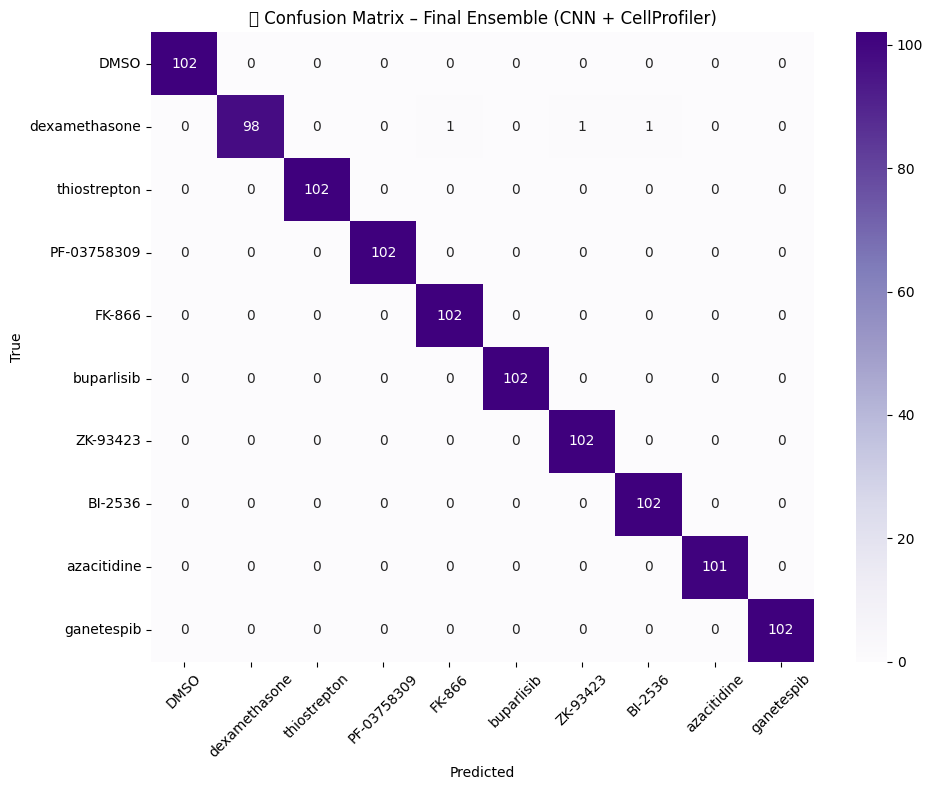

In [ ]:
# Visualize Final Ensemble Confusion Matrix
ensemble_cm = confusion_matrix(y_test_cp, ensemble_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(ensemble_cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=idx_to_compound.values(),
            yticklabels=idx_to_compound.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('📊 Confusion Matrix – Final Ensemble (CNN + CellProfiler)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
print("📋 Classification Report (Ensemble):")
print(classification_report(y_test_cp, ensemble_preds, target_names=[idx_to_compound[i] for i in range(TOP_N)]))

📋 Classification Report (Ensemble):
               precision    recall  f1-score   support

      BI-2536       1.00      1.00      1.00       102
         DMSO       1.00      0.97      0.98       101
       FK-866       1.00      1.00      1.00       102
  PF-03758309       1.00      1.00      1.00       102
     ZK-93423       0.99      1.00      1.00       102
  azacitidine       1.00      1.00      1.00       102
   buparlisib       0.99      1.00      1.00       102
dexamethasone       0.99      1.00      1.00       102
   ganetespib       1.00      1.00      1.00       101
 thiostrepton       1.00      1.00      1.00       102

     accuracy                           1.00      1018
    macro avg       1.00      1.00      1.00      1018
 weighted avg       1.00      1.00      1.00      1018



32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 781ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
<ipython-input-71-e9a5af58f95b>:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


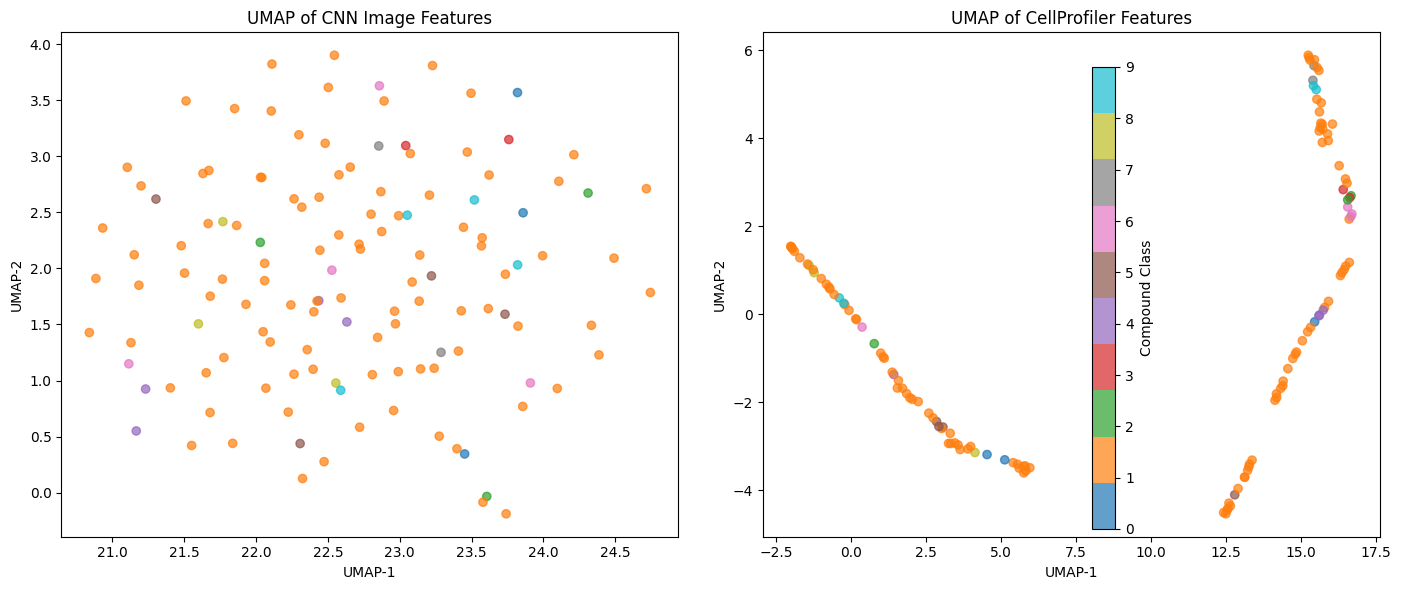

In [71]:
# Step 1: Extract and scale CNN features
feature_extractor = Model(inputs=model_mc.input, outputs=model_mc.layers[-3].output)
X_all_mc = X_test_mc_aligned  # Ensure this is the same length as scaled_cp
cnn_features_all = feature_extractor.predict(X_all_mc)
cnn_scaled_all = StandardScaler().fit_transform(cnn_features_all)

# Step 2: Prepare CellProfiler features and labels
scaled_cp_df = pd.DataFrame(scaled_cp)
scaled_cp_df.index = y_cp.index  # Ensure correct index
X_cp = scaled_cp_df
y_cp = y_cp  # Already set

# Step 3: Shared train/test split for BOTH CNN and CellProfiler
X_cp_train, X_cp_test, y_cp_train, y_cp_test, idx_train, idx_test = train_test_split(
    X_cp, y_cp, X_cp.index, test_size=0.2, stratify=y_cp, random_state=42
)
X_cnn_test = cnn_scaled_all[idx_test]  # Apply same split to CNN features
y_cnn_test = y_cp.loc[idx_test].reset_index(drop=True)  # For color consistency

# Step 4: UMAP for both
umap_cnn = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(X_cnn_test)
umap_cp = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(X_cp_test)

# Step 5: Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# CNN UMAP
axes[0].scatter(umap_cnn[:, 0], umap_cnn[:, 1], c=y_cnn_test, cmap='tab10', alpha=0.7)
axes[0].set_title("UMAP of CNN Image Features")
axes[0].set_xlabel("UMAP-1")
axes[0].set_ylabel("UMAP-2")

# CellProfiler UMAP
sc2 = axes[1].scatter(umap_cp[:, 0], umap_cp[:, 1], c=y_cnn_test, cmap='tab10', alpha=0.7)
axes[1].set_title("UMAP of CellProfiler Features")
axes[1].set_xlabel("UMAP-1")
axes[1].set_ylabel("UMAP-2")

# Colorbar
fig.colorbar(sc2, ax=axes.ravel().tolist(), ticks=range(TOP_N), label="Compound Class")
plt.tight_layout()
plt.show()

In [ ]:
# Include a CellProfiler feature table sample
import pandas as pd
pd.Series(xgb.feature_importances_, index=cp_features.columns).sort_values(ascending=False).head(10)

,0
AreaShape_SpatialMoment_1_0,0.056540
Intensity_StdIntensityEdge_Cells,0.054176
AreaShape_InertiaTensor_1_1,0.047914
AreaShape_BoundingBoxArea,0.036158
Number_Object_Number,0.029981
AreaShape_Area,0.028234
Intensity_MaxIntensityEdge_Cells,0.025482
Intensity_IntegratedIntensity_Cells,0.023370
Intensity_MinIntensity_Cells,0.022691
Intensity_MADIntensity_Cells,0.020608


**Drug Treatment Prediction from Cell Segmentation Features Extracted Using Cellpose**


Running Cellpose on metadata: 100%|██████████| 3456/3456 [00:00<00:00, 4533.23it/s]

Running Cellpose on example data: 100%|██████████| 5/5 [06:07<00:00, 73.42s/it]


Not enough valid metadata or example data to train/test.


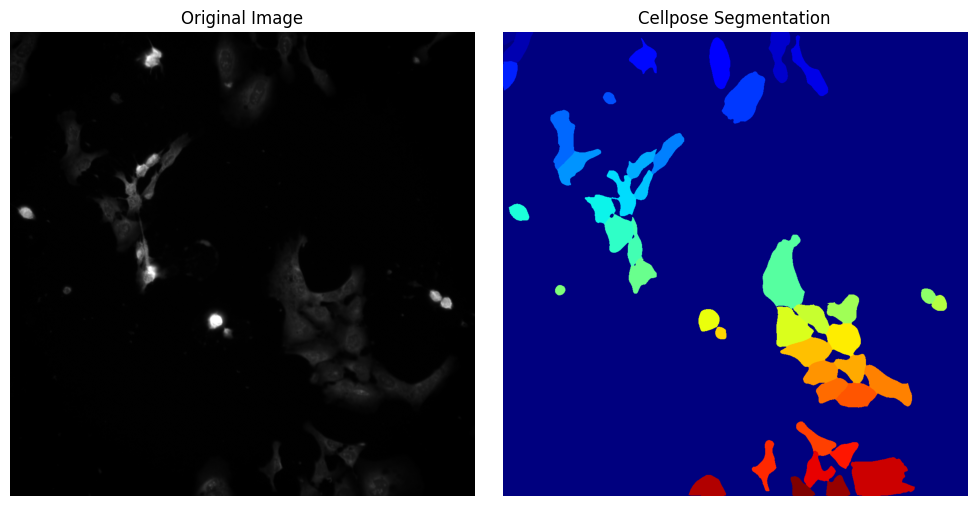

In [179]:
import os
from cellpose import models
from skimage.io import imread
from skimage.measure import regionprops, label
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Load model with GPU if available
model_cp = models.Cellpose(gpu=True, model_type='cyto')

# Define Cellpose feature extraction
def extract_cellpose_features(image_path):
    try:
        img = imread(image_path)
        if img.ndim == 3:
            img = img[:, :, 0]
        masks, _, _, _ = model_cp.eval(img, diameter=None, channels=[0, 0])
        lbl = label(masks)
        props = regionprops(lbl)
        areas = [p.area for p in props]
        return {
            'num_cells': len(areas),
            'avg_area': np.mean(areas) if areas else 0,
            'max_area': np.max(areas) if areas else 0,
            'success': True
        }
    except Exception as e:
        return {'num_cells': 0, 'avg_area': 0, 'max_area': 0, 'success': False}

# Load metadata and extract features
metadata_path = "/content/drive/My Drive/metadata_BR00116991.csv"
metadata_features = []

if os.path.exists(metadata_path):
    metadata = pd.read_csv(metadata_path)
    metadata["filepath"] = metadata["FileName_OrigRNA"].apply(
        lambda x: os.path.join("./downsampled_data", x)
    )

    for _, row in tqdm(metadata.dropna(subset=["filepath", "Metadata_pert_iname"]).iterrows(),
                       total=len(metadata), desc="Running Cellpose on metadata"):
        feats = extract_cellpose_features(row["filepath"])
        feats['compound'] = row["Metadata_pert_iname"]
        feats['image_path'] = row["filepath"]
        metadata_features.append(feats)

    metadata_df = pd.DataFrame(metadata_features)
    metadata_df = metadata_df[metadata_df['success']]
    metadata_df = metadata_df.drop(columns=['success'])
else:
    print("Metadata file not found.")
    metadata_df = pd.DataFrame()

# Load example data and extract features
example_dir = "/content/drive/My Drive/example_data"
example_paths = [os.path.join(example_dir, f) for f in os.listdir(example_dir) if f.endswith(".tiff")]

example_records = []
for path in tqdm(example_paths, desc="Running Cellpose on example data"):
    feats = extract_cellpose_features(path)
    fname = os.path.basename(path)
    try:
        parts = fname.split("-")
        label = parts[-1].replace(".tiff", "")
    except:
        label = "unknown"
    feats['compound'] = label
    feats['image_path'] = path
    example_records.append(feats)

example_df = pd.DataFrame(example_records)
example_df = example_df[example_df['success']]
example_df = example_df.drop(columns=['success'])

# Train model on metadata and test on example_data
if len(metadata_df) > 0 and len(example_df) > 0:
    X_train = metadata_df[['num_cells', 'avg_area', 'max_area']]
    y_train = metadata_df['compound']
    X_test = example_df[['num_cells', 'avg_area', 'max_area']]
    y_test = example_df['compound']

    clf = RandomForestClassifier(random_state=42, n_estimators=100)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    print("Classification Report (Trained on Metadata, Tested on Example Data):")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
else:
    print("Not enough valid metadata or example data to train/test.")

# Visualize one result
if len(example_df) > 0:
    sample_path = example_df.iloc[0]['image_path']
    img = imread(sample_path)
    if img.ndim == 3:
        img = img[:, :, 0]
    masks, _, _, _ = model_cp.eval(img, diameter=None, channels=[0, 0])

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks, cmap='jet')
    plt.title("Cellpose Segmentation")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No example data available to visualize.")